In [1]:
'''
pip install -U -q segmentation-models
pip install opencv-python
pip install azureml-automl-core
'''

'\npip install -U -q segmentation-models\npip install opencv-python\npip install azureml-automl-core\n'

In [2]:
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

Segmentation Models: using `keras` framework.


In [3]:
print(tf. __version__)

2.9.1


In [4]:
from azureml.core import Experiment
from azureml.core import Model
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [5]:
from azureml.core import Run

In [6]:
import azureml.core
from azureml.core import Workspace

# Load the workspace from the saved config file
ws = Workspace.from_config()
print('Ready to use Azure ML {} to work with {}'.format(azureml.core.VERSION, ws.name))

Ready to use Azure ML 1.44.0 to work with mlmodel


In [7]:
# Create an Azure ML experiment in your workspace
experiment = Experiment(workspace=ws, name="mslearn-train")
run = experiment.start_logging()
print("Starting experiment:", experiment.name)

Starting experiment: mslearn-train


In [8]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [9]:
SIZE_X = 128 #Resize images (height  = X, width = Y)
SIZE_Y = 128

In [10]:
cd /home/azureuser/cloudfiles/code/dataset

/mnt/batch/tasks/shared/LS_root/mounts/clusters/segmodel/code/dataset


In [11]:
ls

IoU.png*          Untitled2.ipynb*  seg-accuracy.png*  segmentation_service/
Untitled.ipynb*   loss.png*         seg-loss.png*      test/
Untitled1.ipynb*  seg-IoU.png*      seg_model-1.h5*    train/


In [12]:
# Prepare training raw chest X-ray data
train_images = []
for directory_path in glob.glob('train/raw_images/images'):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        train_images.append(img)

        #train_labels.append(label)
#Convert list to array for machine learning processing        
train_images = np.array(train_images)
print(train_images.shape)

(9568, 128, 128)


In [13]:
# Prepare training mask data
train_masks = [] 
for directory_path in glob.glob('train/mask_images/images'):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        train_masks.append(mask)
        
        #train_labels.append(label)
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)
print(train_masks.shape)

(9568, 128, 128)


In [14]:
#Use customary x_train and y_train variables
X = train_images
Y = train_masks

In [15]:
X = np.expand_dims(X, axis=3)
Y = np.expand_dims(Y, axis=3)

In [16]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=42)

In [17]:
# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

In [18]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

In [19]:
#define u-net network
def build_unet(shape):
    input_layer = Input(shape = shape)
    
    conv1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(input_layer)
    conv1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(conv1)
    pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
    
    conv2 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(conv2)
    pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(conv3)
    pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(conv4)
    pool4 = MaxPooling2D(pool_size = (2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(conv5)
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides = (2, 2), padding = 'same')(conv5), conv4], axis = 3)
    conv6 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(up6)
    conv6 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides = (2, 2), padding = 'same')(conv6), conv3], axis = 3)
    conv7 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(up7)
    conv7 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides = (2, 2), padding = 'same')(conv7), conv2], axis = 3)
    conv8 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(up8)
    conv8 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides = (2, 2), padding = 'same')(conv8), conv1], axis = 3)
    conv9 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(up9)
    conv9 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation = 'sigmoid')(conv9)
    
    return Model(input_layer, conv10)

In [20]:
# define model
model = build_unet((128, 128, 1))

2022-08-22 22:43:10.841418: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-22 22:43:11.581408: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7434 MB memory:  -> device: 0, name: Tesla M60, pci bus id: 0001:00:00.0, compute capability: 5.2


In [21]:
#  define dice coefficient function and dice coefficient loss function
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_true_f = K.cast(y_true_f, 'float32') # new
    y_pred_f = K.flatten(y_pred)
    y_pred_f = K.cast(y_pred_f, 'float32') # new
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [22]:
# define iou function for evaluate similarity of predicted mask and ground truth
def my_iou(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    iou_result = ( K.sum(intersection)+1.0)/(K.sum(y_true_f)+K.sum(y_pred_f)-K.sum(intersection)+1.0)
    return iou_result

In [23]:
from keras import backend as K

In [24]:
# compile the model
model.summary()
model.compile(optimizer = Adam(lr = 1e-5), loss = dice_coef_loss, metrics = [my_iou, 'binary_accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [25]:
# train the model
history=model.fit(x_train, 
          y_train,
          batch_size=50, 
          epochs=40,
          verbose=1,
          validation_data=(x_val, y_val))

Epoch 1/40


2022-08-22 22:43:15.156509: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2022-08-22 22:43:15.532140: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


134/134 [==============================] - 60s 390ms/step - loss: -0.5767 - my_iou: 0.5181 - binary_accuracy: 0.4799 - val_loss: -0.8607 - val_my_iou: 0.8421 - val_binary_accuracy: 0.0852
Epoch 2/40
134/134 [==============================] - 48s 358ms/step - loss: -0.9199 - my_iou: 0.9398 - binary_accuracy: 0.2164 - val_loss: -1.0052 - val_my_iou: 1.0789 - val_binary_accuracy: 0.3249
Epoch 3/40
134/134 [==============================] - 47s 355ms/step - loss: -1.0148 - my_iou: 1.1187 - binary_accuracy: 0.4203 - val_loss: -1.0465 - val_my_iou: 1.1586 - val_binary_accuracy: 0.5148
Epoch 4/40
134/134 [==============================] - 48s 355ms/step - loss: -1.0386 - my_iou: 1.1718 - binary_accuracy: 0.4969 - val_loss: -1.0589 - val_my_iou: 1.1924 - val_binary_accuracy: 0.5227
Epoch 5/40
134/134 [==============================] - 48s 356ms/step - loss: -1.0461 - my_iou: 1.1963 - binary_accuracy: 0.5031 - val_loss: -1.0617 - val_my_iou: 1.2018 - val_binary_accuracy: 0.4995
Epoch 6/40
134/1

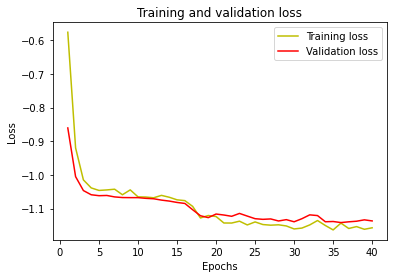

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('seg-loss.png')
plt.show()

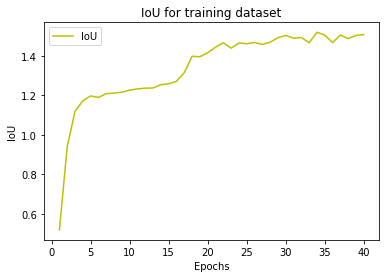

In [27]:
iou = history.history['my_iou']
epochs = range(1, len(iou) + 1)
plt.plot(epochs, iou, 'y', label='IoU')
plt.title('IoU for training dataset')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.savefig('seg-IoU.png')
plt.show()

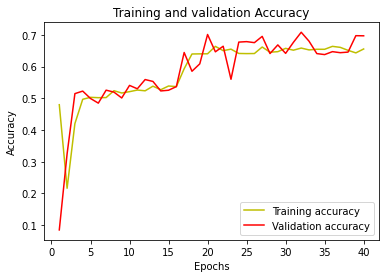

In [28]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('seg-accuracy.png')
plt.show()

In [29]:
ls

IoU.png*          Untitled2.ipynb*  seg-accuracy.png*  segmentation_service/
Untitled.ipynb*   loss.png*         seg-loss.png*      test/
Untitled1.ipynb*  seg-IoU.png*      seg_model-1.h5*    train/


In [30]:
os.path.dirname(os.path.abspath("__file__"))

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/segmodel/code/dataset'

In [31]:
from azure.storage.blob import BlobServiceClient,BlobClient, ContainerClient
import os
ABS_PATH = os.path.dirname(os.path.abspath("__file__"))
seg_loss_file_name='seg-loss.png'
seg_loss_file_name_path=ABS_PATH+'/seg-loss.png'
seg_accuracy_file_name='seg-accuracy.png'
seg_accuracy_file_name_path=ABS_PATH+'/seg-accuracy.png'
upload_container_name = "uploadpictures"
connect_str="DefaultEndpointsProtocol=https;AccountName=phnpictures;AccountKey=Y/cxu5MaNquYVS92Gp+J4hcgxt1jhBpws31SYJc9bYgNdcJYESgU2NulYmPMIujZZVoHdk1C0an/+AStCRPElQ==;EndpointSuffix=core.windows.net"

def upload_pictures_to_blob(container_name,file_name,file_path):
    blob_service_client = BlobServiceClient.from_connection_string(connect_str)
    blob_client=blob_service_client.get_blob_client(container=container_name,blob= file_name)
    with open(file_path, "rb") as data:
        blob_client.upload_blob(data,overwrite=True)

upload_pictures_to_blob(upload_container_name,seg_loss_file_name,seg_loss_file_name_path)
upload_pictures_to_blob(upload_container_name,seg_accuracy_file_name,seg_accuracy_file_name_path)

In [32]:
print("acc:", history.history['binary_accuracy'][39])
print("iou:", history.history['my_iou'][39])
run.log('Accuracy', np.float(history.history['binary_accuracy'][39]))
run.log('IOU', np.float(history.history['my_iou'][39]))

acc: 0.6555302143096924
iou: 1.5067507028579712


/tmp/ipykernel_454718/2897775612.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  run.log('Accuracy', np.float(history.history['binary_accuracy'][39]))
/tmp/ipykernel_454718/2897775612.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  run.log('IOU', np.float(history.history['my_iou'][39]))


In [33]:
# Save the trained model
model_file = 'seg_model-1.h5'
model.save('seg_model-1.h5')
run.upload_file(name = 'outputs/' + model_file, path_or_stream = './' + model_file)

In [34]:
# Complete the run
run.complete()

In [35]:
# Register the model
run.register_model(model_path='outputs/seg_model-1.h5', 
                   model_name='seg_model-1',
                   tags={'Training context':'Inline Training'},
                   properties={'my_iou': run.get_metrics()['IOU'],'binary_accuracy': run.get_metrics()['Accuracy']}
                   )
#
print('Model trained and registered.')

Model trained and registered.


In [36]:
from azureml.core import Model

for model in Model.list(ws):
    print(model.name, 'version:', model.version)
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print ('\t',tag_name, ':', tag)
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print ('\t',prop_name, ':', prop)
    print('\n')

seg_model-1 version: 3
	 Training context : Inline Training
	 my_iou : 1.5067507028579712
	 binary_accuracy : 0.6555302143096924


seg_model-1 version: 2
	 Training context : Inline Training
	 my_iou : 1.4343639612197876
	 binary_accuracy : 0.6266193985939026


seg_model-1 version: 1
	 Training context : Inline Training
	 my_iou : [1.5132300853729248, 1.5132300853729248]
	 binary_accuracy : [0.6529854536056519, 0.6529854536056519]




In [37]:
model = ws.models['seg_model-1']
print(model.name, 'version', model.version)

seg_model-1 version 3


In [38]:
import os

# Create a folder for the deployment files
deployment_folder = './segmentation_service'
os.makedirs(deployment_folder, exist_ok=True)
print(deployment_folder, 'folder created.')

# Set path for scoring script
script_file = 'score_pneumothorax.py'
script_path = os.path.join(deployment_folder,script_file)

./segmentation_service folder created.


In [39]:
%%writefile $script_path
import json
import numpy as np
import os
from tensorflow import keras
import tensorflow as tf


def init():
    global model
    print("init start")
    # Get the path to the deployed model file and load it
    model_path = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'seg_model-1.h5')  
    model = tf.keras.models.load_model(model_path, compile=False)    

def run(raw_data):
    data = np.array(json.loads(raw_data)["data"])
    y_hat = model.predict(data)

    return y_hat.tolist()

Overwriting ./segmentation_service/score_pneumothorax.py


In [40]:
from azureml.core import Environment
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice
from azureml.automl.core.shared import constants

service_env = Environment(name='service-env-4')
python_packages = [ 'azureml-defaults', 'azure-ml-api-sdk','azureml-sdk','tensorflow-gpu==2.9.1','matplotlib','joblib','numpy']
for package in python_packages:
    service_env.python.conda_dependencies.add_pip_package(package)

inference_config = InferenceConfig(source_directory=deployment_folder,
                                   entry_script=script_file,
                                   environment=service_env)

# Configure the web service container
deployment_config = AciWebservice.deploy_configuration(cpu_cores=1, memory_gb=1)

In [41]:
# Deploy the model as a service
print('Deploying model...')
service_name = "segmentation-service-7"
service = Model.deploy(ws, service_name, [model], inference_config, deployment_config, overwrite=True)
#service = Model.deploy(ws, "local-test", [model], inference_config, deployment_config, overwrite=True)
service.wait_for_deployment(True)
print(service.state)

Deploying model...
Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2022-08-22 23:16:16+00:00 Creating Container Registry if not exists.
2022-08-22 23:16:16+00:00 Registering the environment.
2022-08-22 23:16:17+00:00 Use the existing image.
2022-08-22 23:16:18+00:00 Generating deployment configuration.
2022-08-22 23:16:19+00:00 Submitting deployment to compute.
2022-08-22 23:16:22+00:00 Checking the status of deployment segmentation-service-7..
2022-08-22 23:20:11+00:00 Checking the status of inference endpoint segmentation-service-7.
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


In [42]:
endpoint = service.scoring_uri

In [43]:
print(endpoint)

http://f9653bf0-ca9b-4dd4-96bc-c2ce619bfd3d.westeurope.azurecontainer.io/score


In [44]:
print(service.get_logs())

/bin/bash: /azureml-envs/azureml_ed12fc91d2303c27a81d1a96245ffadd/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /azureml-envs/azureml_ed12fc91d2303c27a81d1a96245ffadd/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /azureml-envs/azureml_ed12fc91d2303c27a81d1a96245ffadd/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /azureml-envs/azureml_ed12fc91d2303c27a81d1a96245ffadd/lib/libtinfo.so.6: no version information available (required by /bin/bash)
2022-08-22T23:19:12,432954701+00:00 - iot-server/run 
2022-08-22T23:19:12,418619028+00:00 - rsyslog/run 
2022-08-22T23:19:12,432559001+00:00 - nginx/run 
bash: /azureml-envs/azureml_ed12fc91d2303c27a81d1a96245ffadd/lib/libtinfo.so.6: no version information available (required by bash)
2022-08-22T23:19:12,481013008+00:00 - gunicorn/run 
2022-08-22T23:19:12,494571681+00:00 | gunicorn/run | 
2022-08-22T23:19:12,506188659+00:00 | gu